In [1]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [2]:
import pandas as pd
import numpy as np

# Use 2023-24 data
df_2023_24 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2023-24'", con)
columns_to_drop = [col for col in df_2023_24.columns if col.startswith("UniReqs") or col.startswith("RegHSDiploma") or col.startswith("Dropout")]

# Lasso

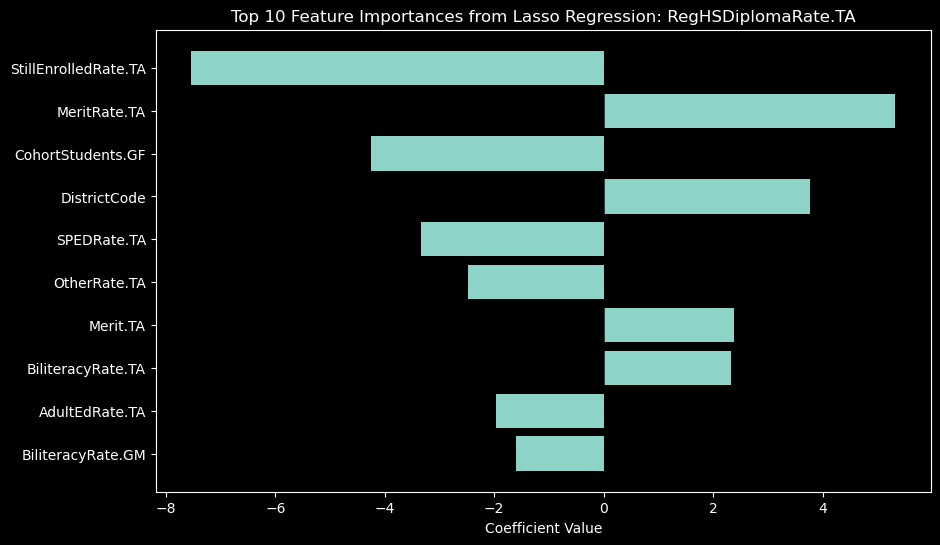

R^2 Score: -0.0014446716626286271
Mean Squared Error: 392.899737135097
Root Mean Squared Error: 19.821698644038985


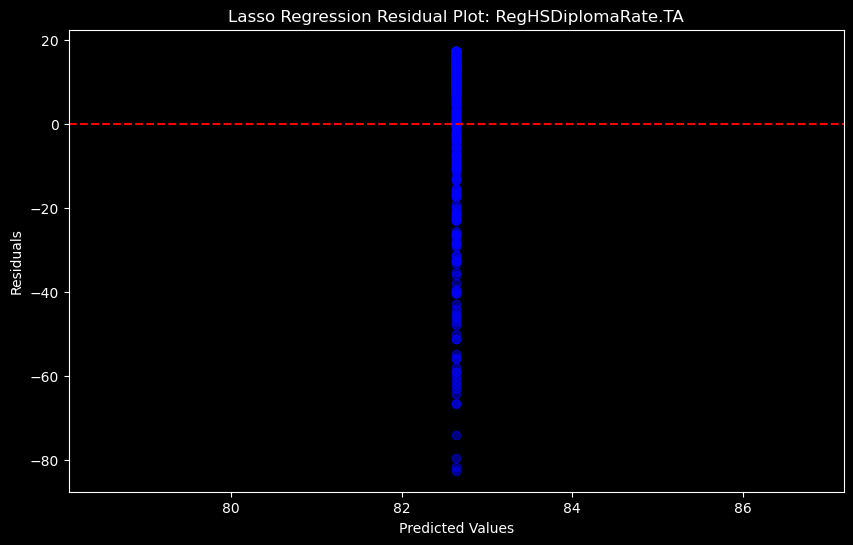

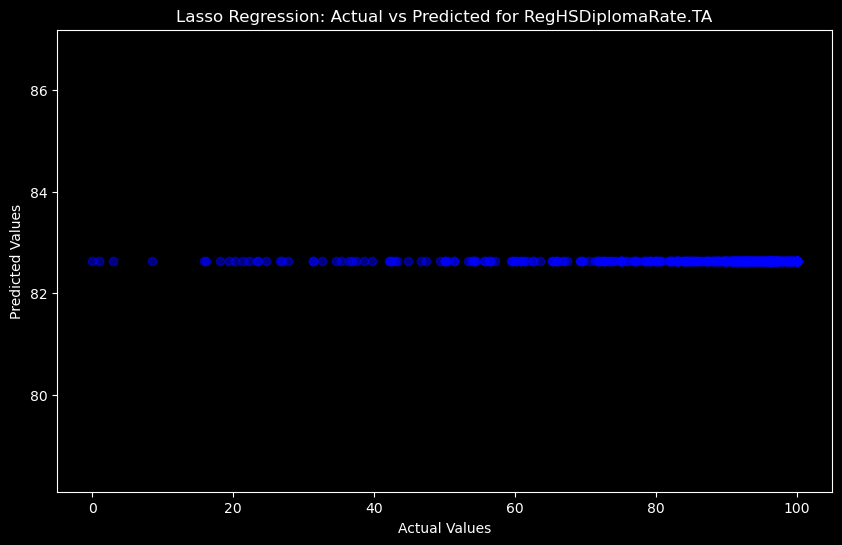

In [3]:
import modeling.utils.lasso as lasso_utils

target_column = "RegHSDiplomaRate.TA"

X_numeric, y, sorted_pairs = lasso_utils.fit_lasso_model(
    df_2023_24, target_column, columns_to_drop
)
lasso_utils.plot_lasso_coefficients(target_column, sorted_pairs)
lasso_model = lasso_utils.LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_results = lasso_utils.train_and_evaluate_lasso_model(X_numeric, y, lasso_model)
print(f"R^2 Score: {lasso_results['r2']}")
print(f"Mean Squared Error: {lasso_results['mse']}")
print(f"Root Mean Squared Error: {lasso_results['rmse']}")
lasso_utils.plot_lasso_residuals(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)
lasso_utils.plot_actual_predicted_lasso(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)

### CSU/UC Graduation Rate

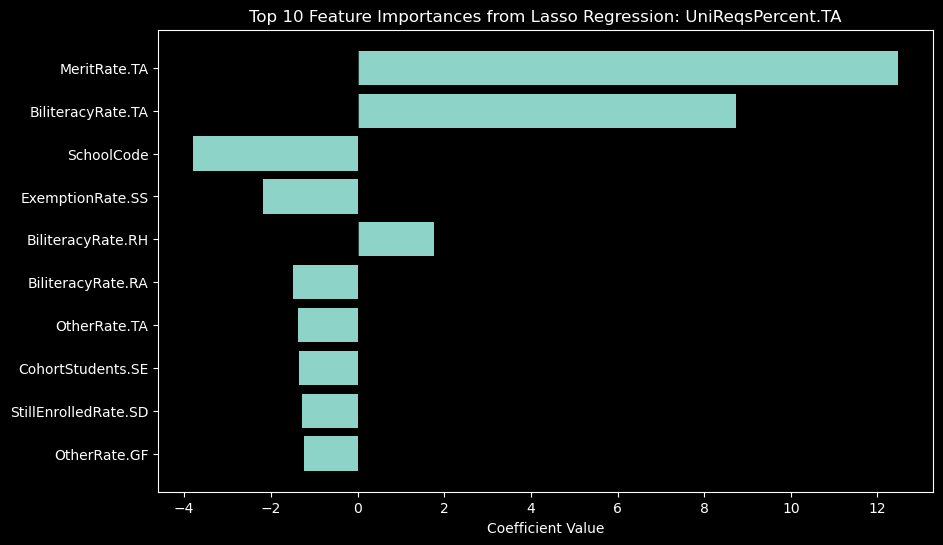

R^2 Score: 0.01687570552123785
Mean Squared Error: 1012.7568932814946
Root Mean Squared Error: 31.823841585853437


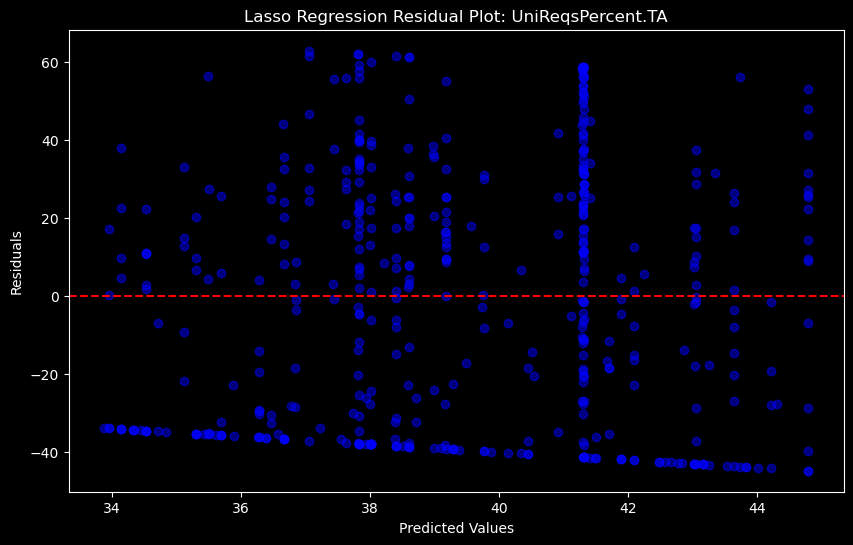

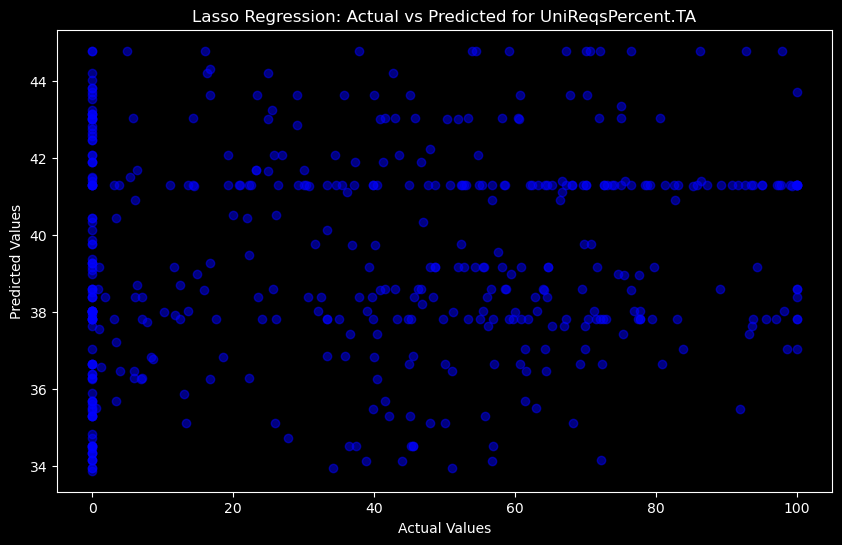

In [4]:
target_column = "UniReqsPercent.TA"


X_numeric, y, sorted_pairs = lasso_utils.fit_lasso_model(
    df_2023_24, target_column, columns_to_drop
)


lasso_utils.plot_lasso_coefficients(target_column, sorted_pairs)
lasso_model = lasso_utils.LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_results = lasso_utils.train_and_evaluate_lasso_model(X_numeric, y, lasso_model)

print(f"R^2 Score: {lasso_results['r2']}")
print(f"Mean Squared Error: {lasso_results['mse']}")
print(f"Root Mean Squared Error: {lasso_results['rmse']}")

lasso_utils.plot_lasso_residuals(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)
lasso_utils.plot_actual_predicted_lasso(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)

# XGBoost

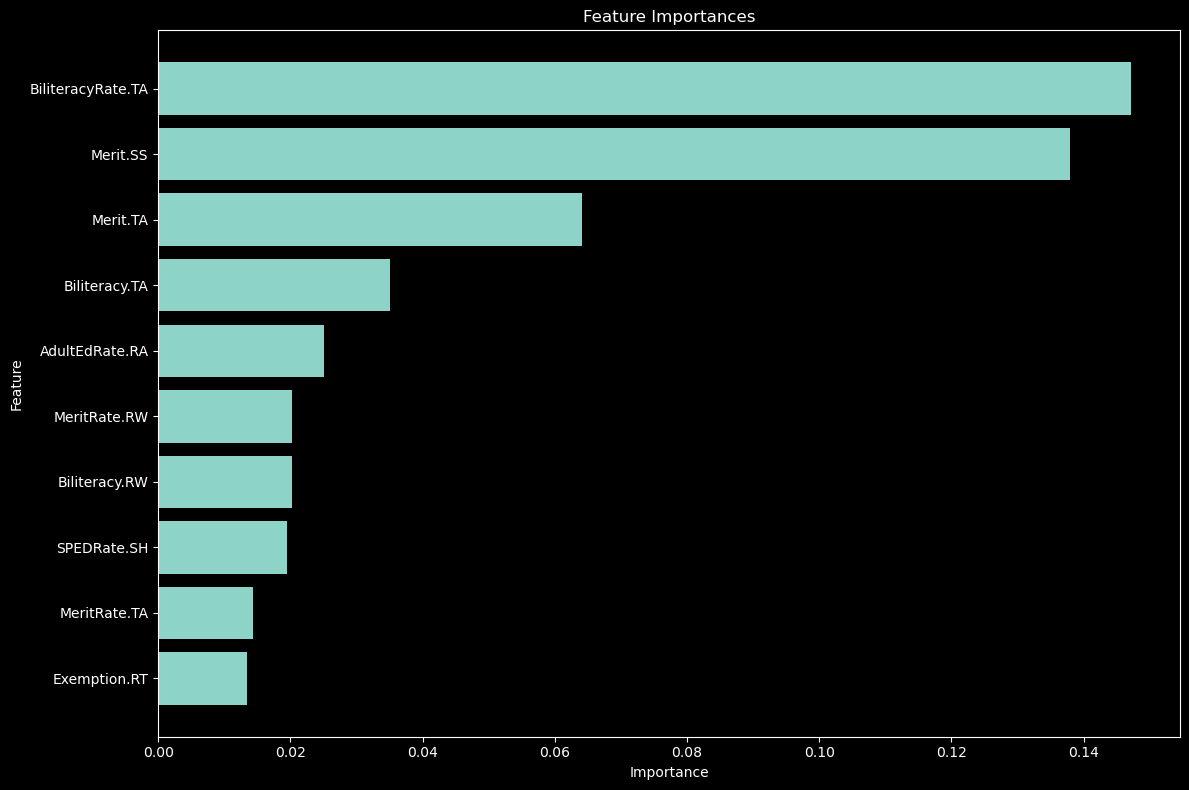

{'MSE': 325.58690038377824, 'RMSE': 18.044026723095325, 'MAE': 12.469885255973708, 'R^2': 0.6839395576028336}


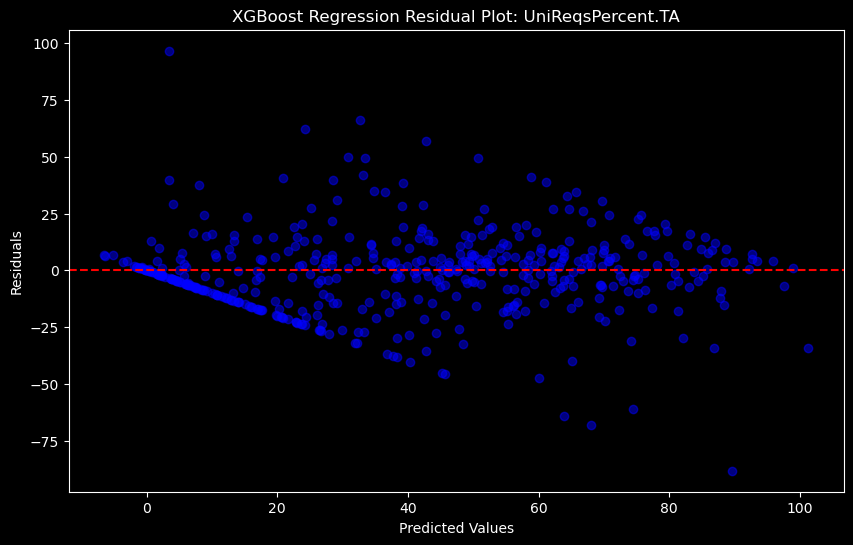

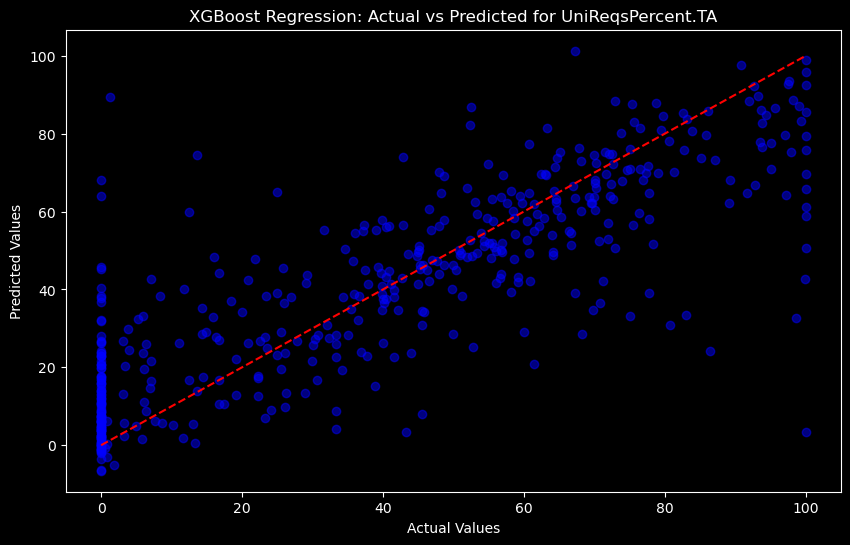

In [5]:
import modeling.utils.xgboost as xgb_utils

target_column = "UniReqsPercent.TA"
xgb_results = xgb_utils.train_xgboost_model(df_2023_24, target_column, columns_to_drop)
print(xgb_results["metrics"])
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

## Graduation Rate

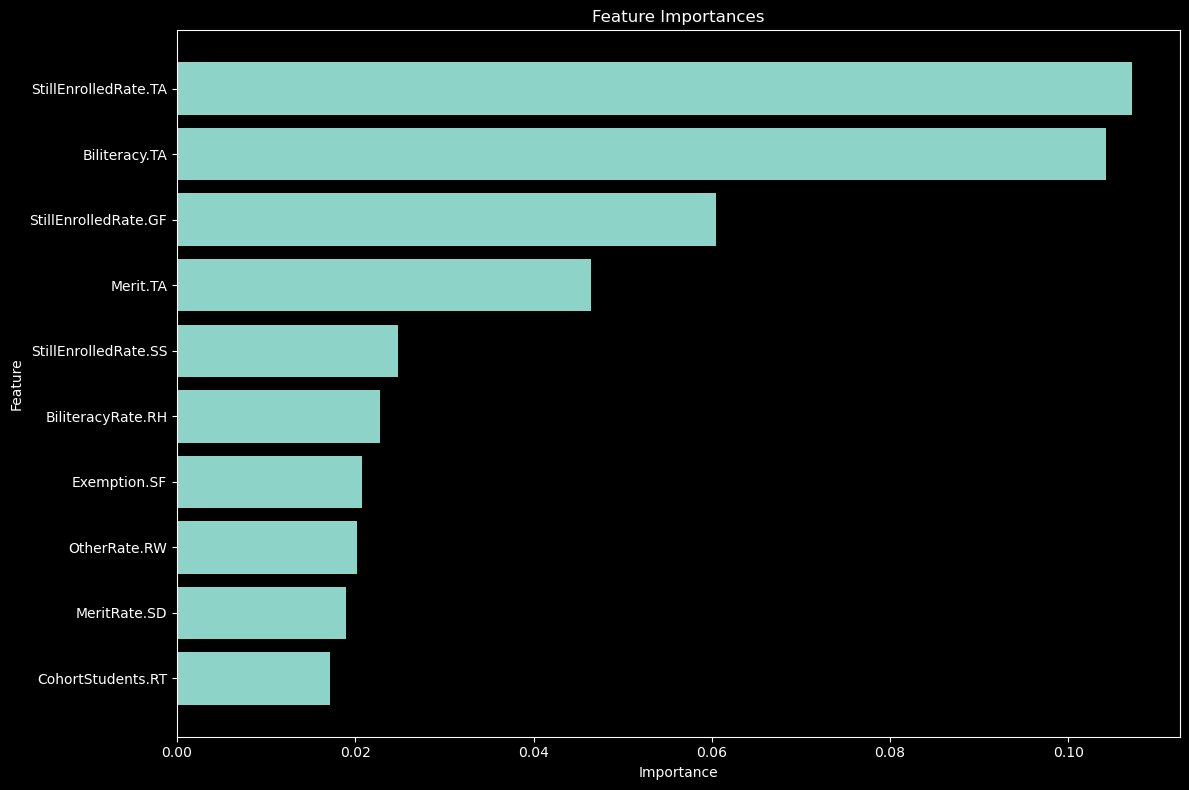

{'MSE': 166.52584016334686, 'RMSE': 12.90448914770929, 'MAE': 7.737384174396466, 'R^2': 0.5755496897459509}


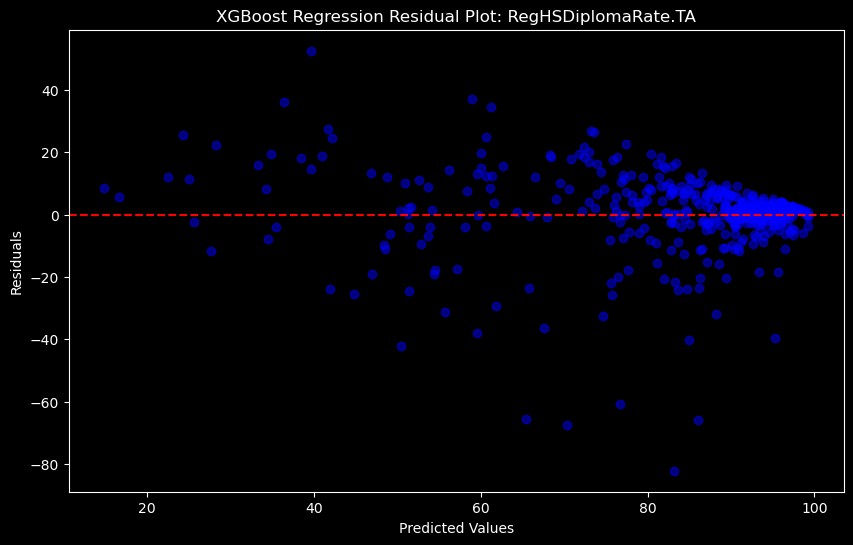

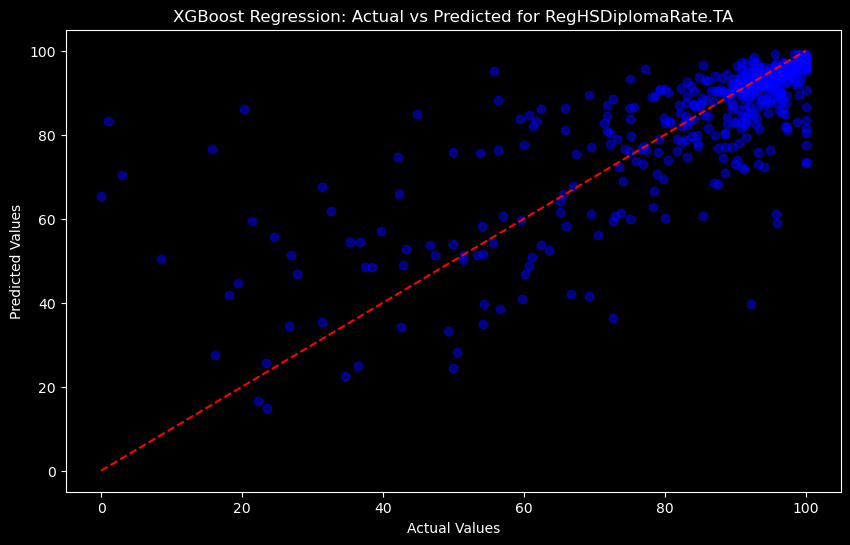

In [6]:
target_column = "RegHSDiplomaRate.TA"
xgb_results = xgb_utils.train_xgboost_model(df_2023_24, target_column, columns_to_drop)
print(xgb_results["metrics"])
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

# Random Forest

Predict Graduation Rate

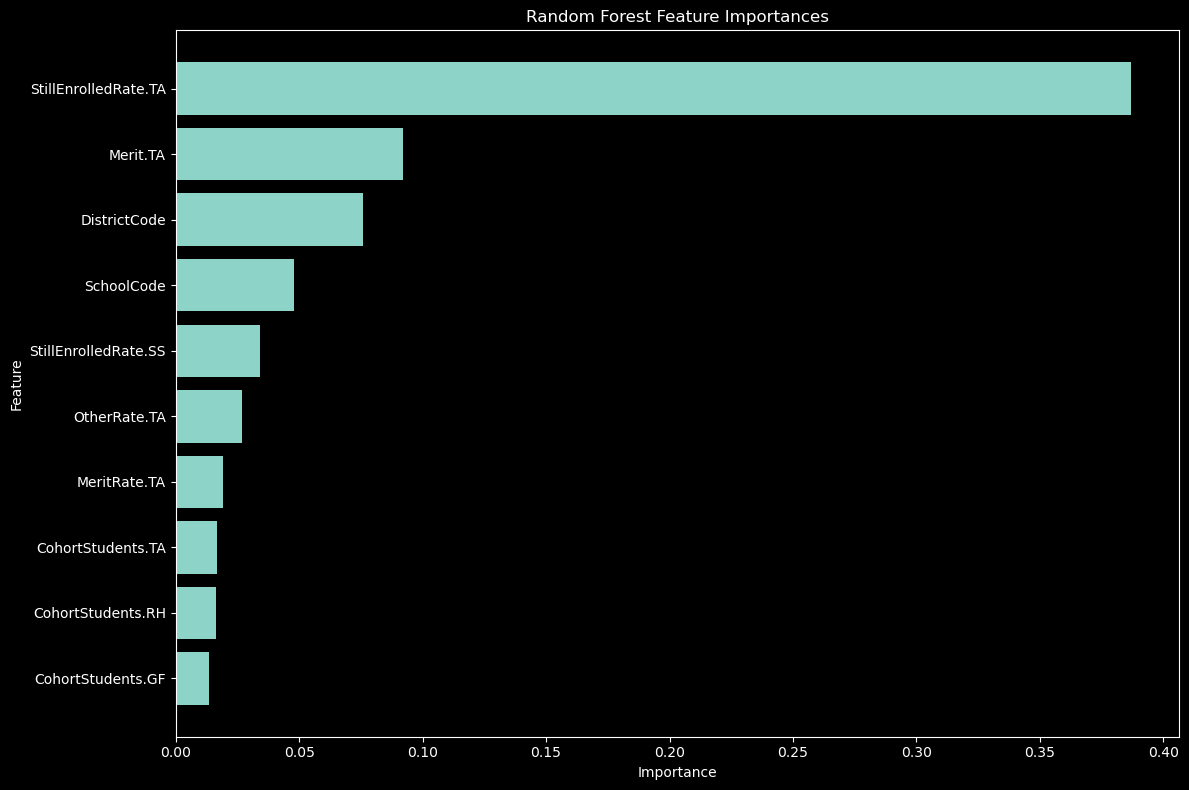

{'MSE': 143.58317673780346, 'RMSE': 11.982619777736563, 'R²': 0.6339296684442534}


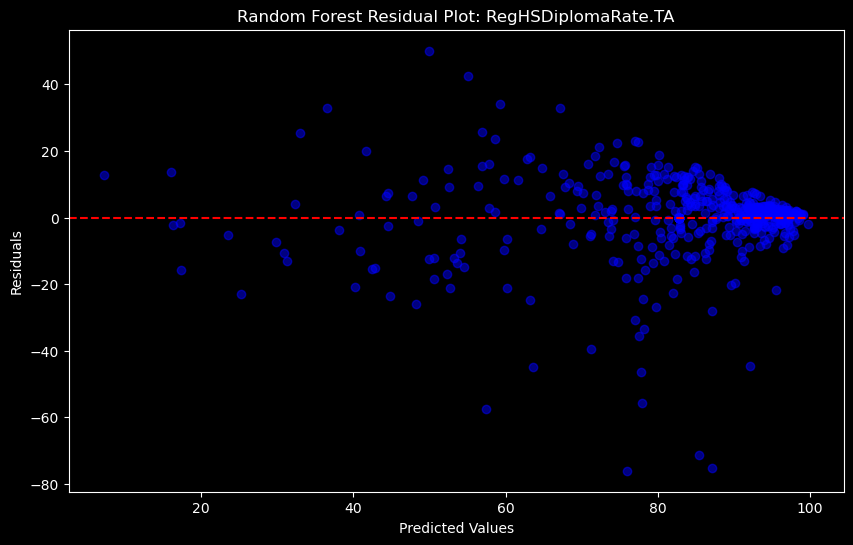

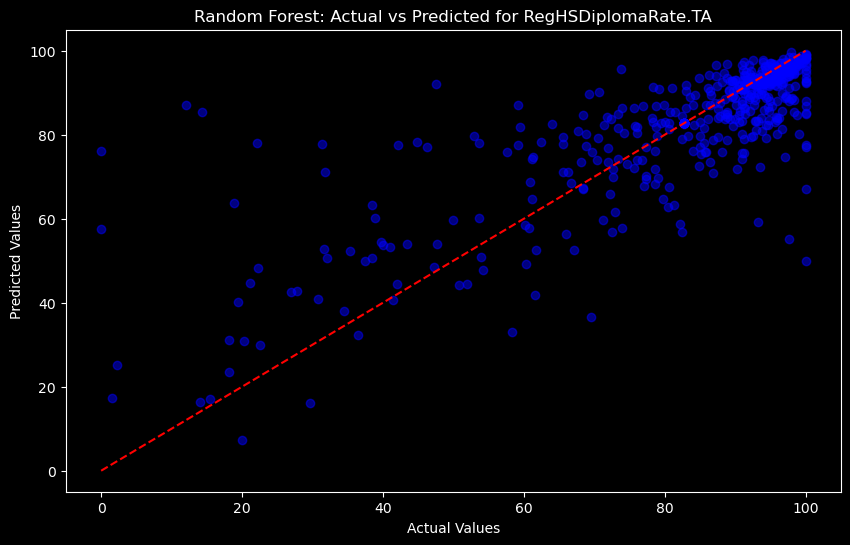

In [7]:
import modeling.utils.randomforest as rf_utils

df_2023_24_clean = df_2023_24.copy()
df_2023_24_clean = df_2023_24_clean.select_dtypes(include=[np.number])  # Keep only numeric columns
df_2023_24_clean = df_2023_24_clean.fillna(df_2023_24_clean.mean())  # Impute with mean

# Filter columns_to_drop to include only columns that exist in merged_clean
columns_to_drop_filtered = [col for col in columns_to_drop if col in df_2023_24_clean.columns]

rf_grad = rf_utils.train_random_forest_model(df_2023_24_clean, "RegHSDiplomaRate.TA", columns_to_drop_filtered)
print(rf_grad["metrics"])
rf_utils.plot_rf_residuals(rf_grad["y_test"], rf_grad["y_pred"], "RegHSDiplomaRate.TA")
rf_utils.plot_rf_actual_predicted(rf_grad["y_test"], rf_grad["y_pred"], "RegHSDiplomaRate.TA")

Predict CSU/UC Readiness


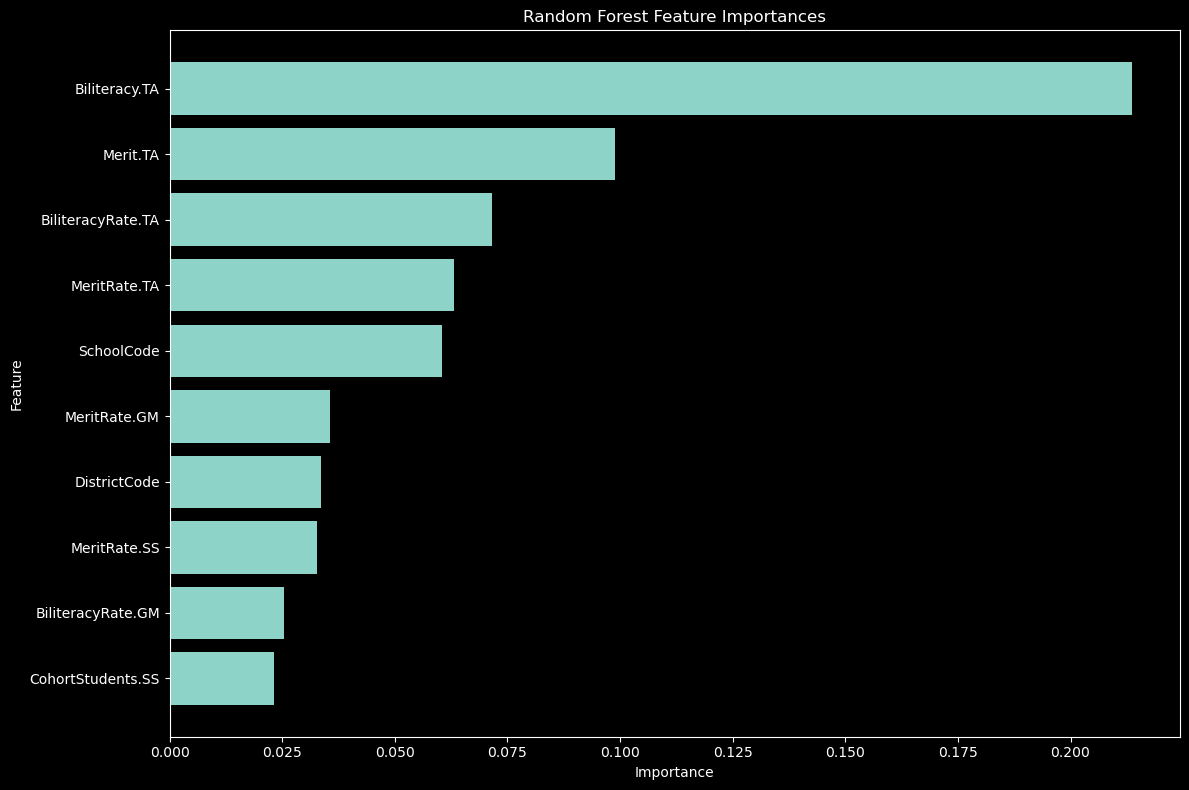

{'MSE': 305.6865210989825, 'RMSE': 17.483893190562064, 'R²': 0.6782552187560389}


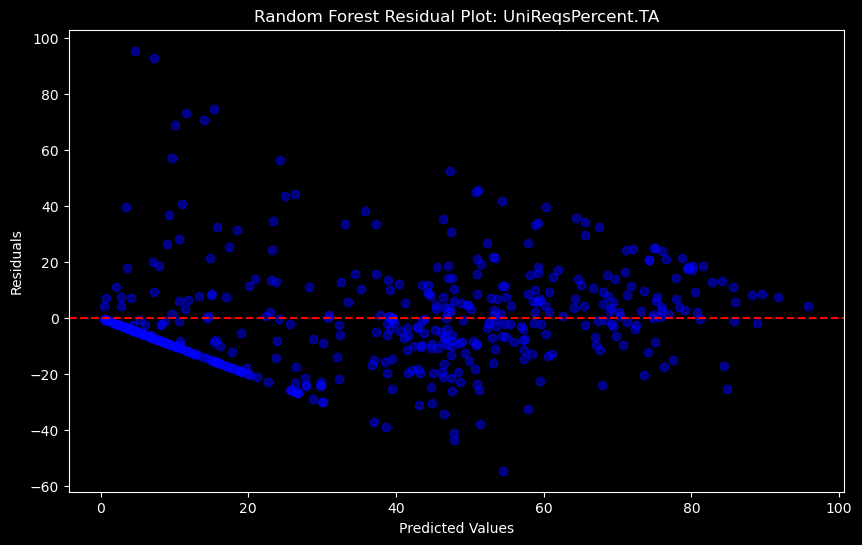

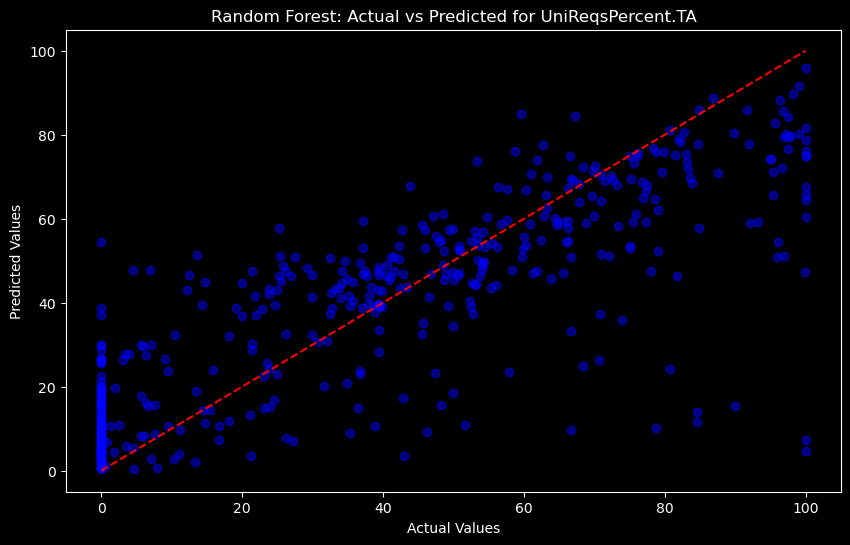

In [8]:
rf_uni = rf_utils.train_random_forest_model(df_2023_24_clean, "UniReqsPercent.TA", columns_to_drop_filtered)
print(rf_uni["metrics"])
rf_utils.plot_rf_residuals(rf_uni["y_test"], rf_uni["y_pred"], "UniReqsPercent.TA")
rf_utils.plot_rf_actual_predicted(rf_uni["y_test"], rf_uni["y_pred"], "UniReqsPercent.TA")

Predict Dropout Rate

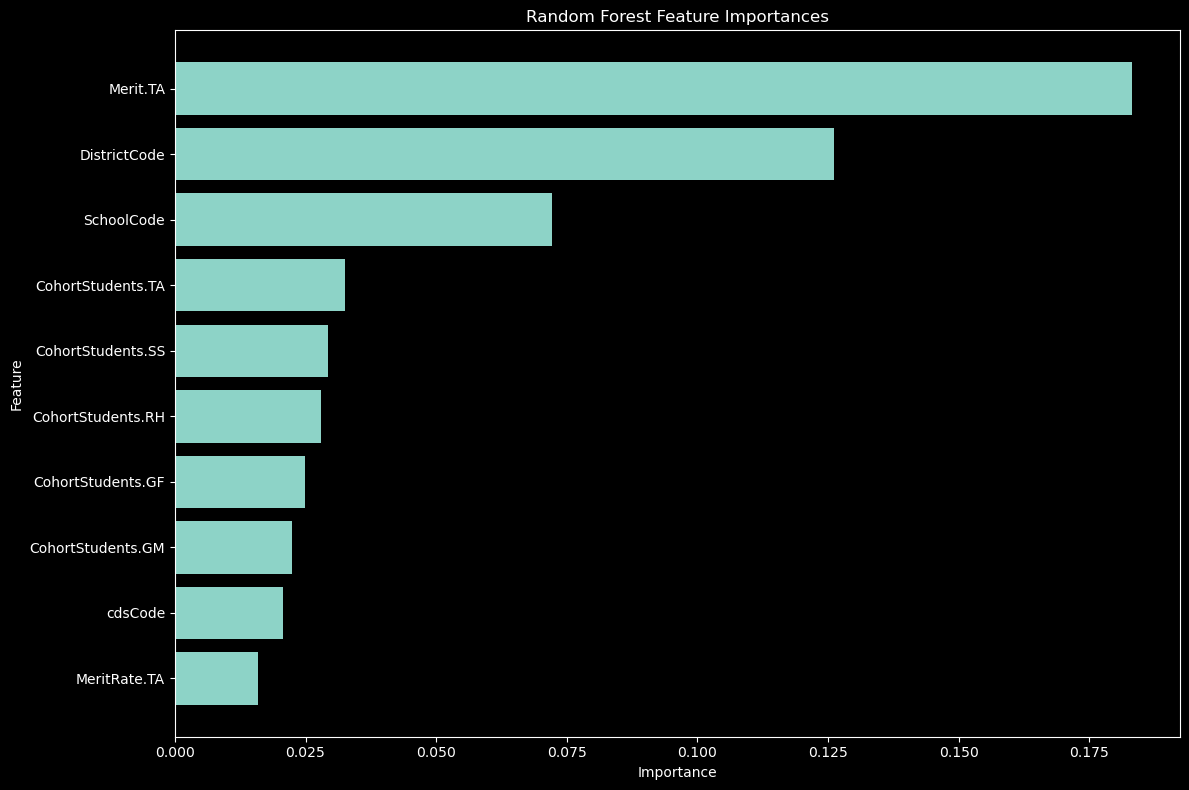

{'MSE': 126.23179154039187, 'RMSE': 11.235292232086884, 'R²': 0.4167314098968701}


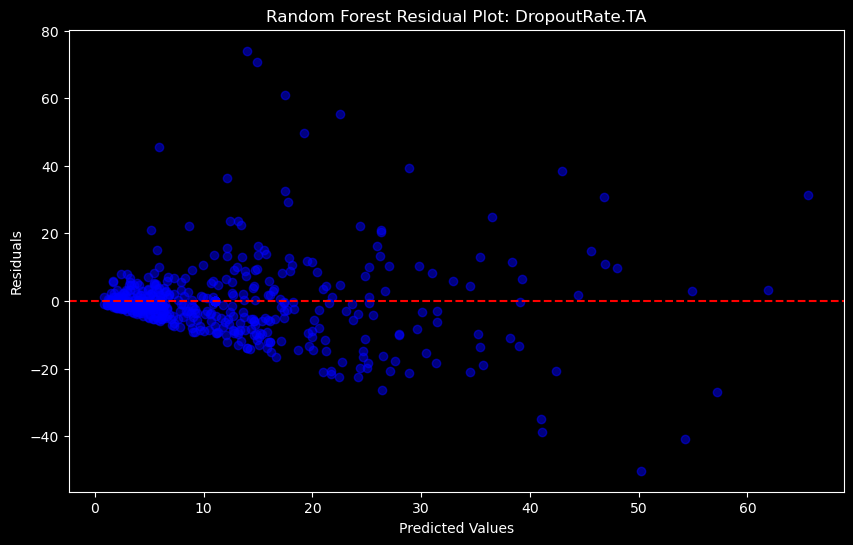

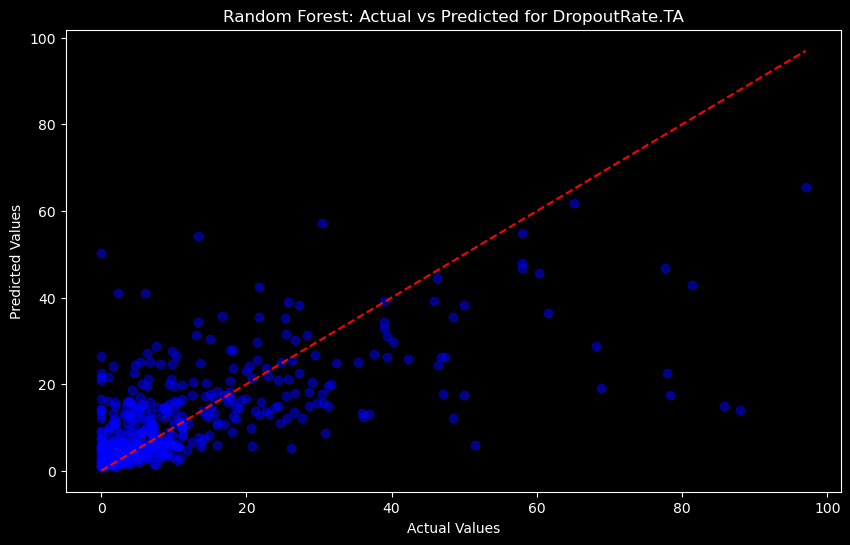

In [9]:
rf_dropout = rf_utils.train_random_forest_model(df_2023_24_clean, "DropoutRate.TA", columns_to_drop_filtered)
print(rf_dropout["metrics"])
rf_utils.plot_rf_residuals(rf_dropout["y_test"], rf_dropout["y_pred"], "DropoutRate.TA")
rf_utils.plot_rf_actual_predicted(rf_dropout["y_test"], rf_dropout["y_pred"], "DropoutRate.TA")